# Tasks for laboratory assignment 2

In [4]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from autocorrect import Speller
import nltk
from wordcloud import WordCloud

import gensim as gs
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2dense
import gensim.downloader as api

import matplotlib.pyplot as plt

import json

# Download the necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## Extract data from the json file 

Write a script, that would extract all the the data from the json file and return it in a list of texts for further use in the next tasks

In [2]:
def extract_texts_from_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        return data['texts']
    return None 

texts = extract_texts_from_file('resources/data.json')
print(texts)

['Oppenheimer, directed by Christopher Nolan, delves into the life of J. Robert Oppenheimer, the theoretical physicist who led the development of the atomic bomb. The film explores his moral and emotional struggles.', "Oppenheimer captures the life of the 'father of the atomic bomb' and his internal conflict after the success of the Manhattan Project. The film's complex narrative reflects on the cost of scientific achievement.", 'In Oppenheimer, Cillian Murphy delivers a riveting performance as the conflicted physicist who grapples with the consequences of his groundbreaking work on the atomic bomb, under the weight of global politics and ethics.', 'Oppenheimer is a cinematic exploration of ambition, guilt, and responsibility. Through stunning visuals and a thought-provoking story, Nolan brings the life of the brilliant but haunted physicist to the big screen.', 'Ducks are versatile waterfowl, known for their adaptability in freshwater and coastal habitats. With webbed feet and waterpr

## Process the texts

Write a script, that would process these texts. Processing should include:

- Lowercasing
- Removing Punctuation
- Removing Special Characters and Numbers
- Stemming or Lemmatization
- Handling Abbreviations
- Spelling Correction

In [5]:
def process_texts(texts):
    lemmatizer = WordNetLemmatizer()

    stop_words = set(stopwords.words('english'))


    processed_texts = []
    
    for text in texts:
        text = text.lower()
        
        tokens = word_tokenize(text)
        
        tokens = [token for token in tokens if token.isalpha() and not token.isdigit()]
        
        tokens = [token for token in tokens if token not in stop_words]
        
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        processed_texts.append(' '.join(tokens))
    
    return processed_texts

texts_processed = process_texts(texts)
print(texts_processed)

['oppenheimer directed christopher nolan delf life robert oppenheimer theoretical physicist led development atomic bomb film explores moral emotional struggle', 'oppenheimer capture life atomic bomb internal conflict success manhattan project film complex narrative reflects cost scientific achievement', 'oppenheimer cillian murphy delivers riveting performance conflicted physicist grapple consequence groundbreaking work atomic bomb weight global politics ethic', 'oppenheimer cinematic exploration ambition guilt responsibility stunning visuals story nolan brings life brilliant haunted physicist big screen', 'duck versatile waterfowl known adaptability freshwater coastal habitat webbed foot waterproof feather excellent swimmer migrating long distance find food warmer climate', 'lamp spider talk yesterday flew nobody noticed except toaster watch blue smell better today door laughing understand whisper secret orange sock', 'duck communicate using range vocalization including quack whistle 

## Visualize as cloud of words

Visualize the texts as a cloud of words.

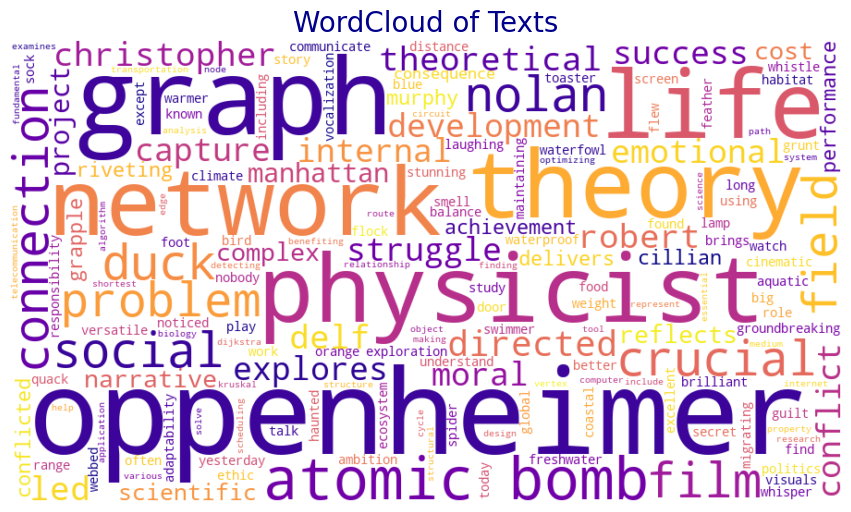

In [ ]:
def visualize_texts(texts_processed):
    all_text = ' '.join(texts_processed)
    
    wordcloud = WordCloud(
        width=900,
        height=500,
        background_color='white',
        colormap='plasma',
        contour_color='black',
        contour_width=1.5,
        max_words=200,
        min_font_size=10,
        random_state=42
    ).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud of Texts", fontsize=20, color='darkblue')
    plt.show()

    return None

visualize_texts(texts_processed)

## Calculate cosine similarities using TFIDF

Calculate the TFIDF score and cosine similarity between the texts. You may use gensim, write your own script using numpy or use other module. Output the result as a matrix $n\times n$ of cosine similarity scores (where $n$ is the length of texts list).

**Extra credit**: use word2vec word embeddings in vector spaces to get better TFIDF scores by representing each word as a vector.

In [13]:
def cosine_similarity_matrix(matrix):
    """Calculate cosine similarity matrix using numpy."""
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1  
    normalized_matrix = matrix / norms
    
    cosine_matrix = np.dot(normalized_matrix, normalized_matrix.T)
    return cosine_matrix

In [ ]:
def calcuate_tfidf(texts_processed):
    tokenized_texts = [text.split() for text in texts_processed]
    
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    tfidf_model = TfidfModel(corpus)
    tfidf_corpus = tfidf_model[corpus]
    
    word2vec_model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=100,  
        window=5,  
        min_count=1, 
        workers=4, 
        sg=0  
    )
    
    document_vectors = []
    
    for _, doc_bow in enumerate(tfidf_corpus):
        doc_vector = np.zeros(word2vec_model.wv.vector_size)
        total_weight = 0.0
        
        for word_id, tfidf_score in doc_bow:
            word = dictionary[word_id]
            
            if word in word2vec_model.wv:
                word_embedding = word2vec_model.wv[word]
                doc_vector += word_embedding * tfidf_score
                total_weight += tfidf_score
        
        if total_weight > 0:
            doc_vector = doc_vector / total_weight
        
        document_vectors.append(doc_vector)
    
    document_vectors_matrix = np.array(document_vectors)
    
    cosine_matrix = cosine_similarity_matrix(document_vectors_matrix)
    
    return cosine_matrix

cosine_matrix = calcuate_tfidf(texts_processed)
print(cosine_matrix)


[[ 1.00000000e+00  1.14409572e-01  9.33773719e-02  1.50252252e-01
  -2.91691439e-02  5.02571592e-03  9.69549337e-02  1.06569175e-02
  -6.62176984e-04 -3.38886231e-02]
 [ 1.14409572e-01  1.00000000e+00  1.45192903e-01 -8.62900494e-02
   2.73244613e-02  9.51097097e-02  1.40387832e-01  2.13035229e-01
  -1.42873190e-01 -5.34122150e-02]
 [ 9.33773719e-02  1.45192903e-01  1.00000000e+00 -1.81351933e-01
   5.28389631e-02  1.25117005e-02  4.62370082e-03  9.30129080e-02
  -1.79001806e-01  1.83286121e-01]
 [ 1.50252252e-01 -8.62900494e-02 -1.81351933e-01  1.00000000e+00
  -1.05587608e-02  1.26002175e-02  7.48939280e-02 -9.79034810e-02
  -1.27128776e-01 -1.22980858e-01]
 [-2.91691439e-02  2.73244613e-02  5.28389631e-02 -1.05587608e-02
   1.00000000e+00 -1.28880764e-01 -1.45280006e-01 -9.34842306e-02
  -1.52257211e-02  4.84546766e-02]
 [ 5.02571592e-03  9.51097097e-02  1.25117005e-02  1.26002175e-02
  -1.28880764e-01  1.00000000e+00  3.13467793e-01  9.31282680e-02
  -1.48941564e-01 -4.95382674e-03

## Visualize data

Visualize the `cosine_matrix` data using matplotlib. Choose your own method of plotting the scores in a way, that the similarity indeces between texts would be instantly visible. Plot data about texts as well (a couple of first words in the document).

*Hint: remember heat maps, aren't they nice for this task?*

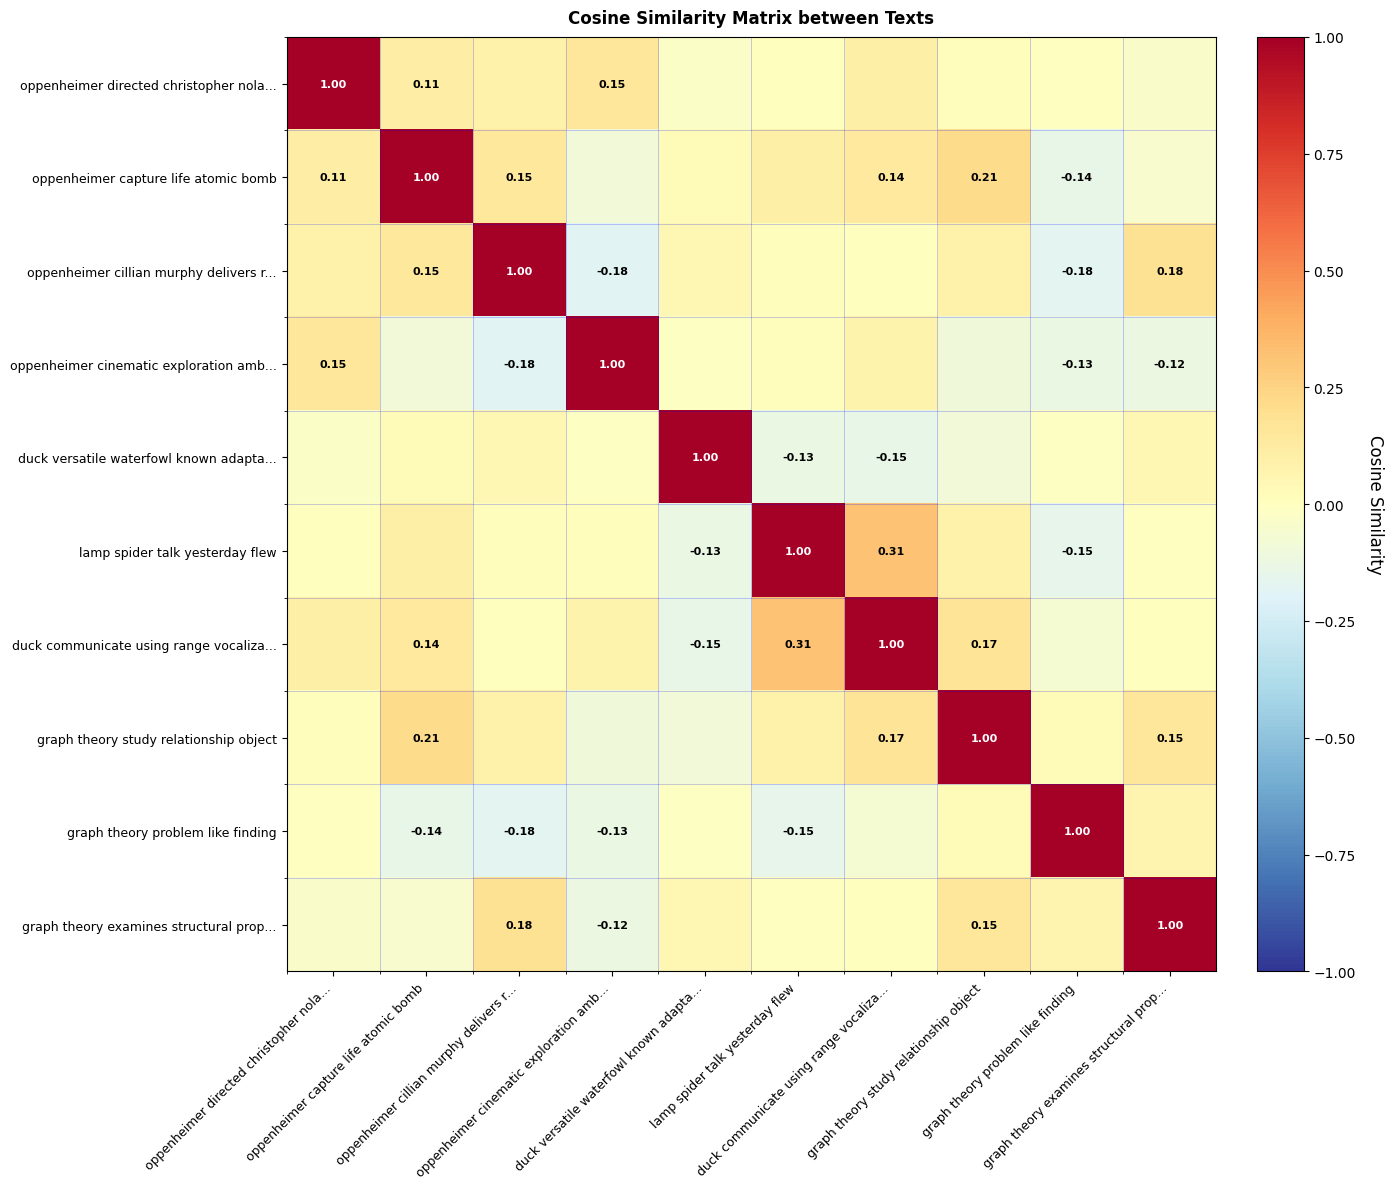

In [18]:
def visualize_data(cosine_matrix, texts_processed):
    cosine_matrix = np.array(cosine_matrix)
    cosine_matrix = np.clip(cosine_matrix, -1, 1)
    
    labels = []
    for text in texts_processed:
        words = text.split()[:5]  
        label = ' '.join(words)
        if len(label) > 40:  
            label = label[:37] + '...'
        labels.append(label)
    
    _, ax = plt.subplots(figsize=(14, 12))
    
    im = ax.imshow(cosine_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(labels, fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Cosine Similarity', rotation=270, labelpad=20, fontsize=12)
    
    threshold = 0.1  
    for i in range(len(labels)):
        for j in range(len(labels)):
            value = cosine_matrix[i, j]
            if abs(value) >= threshold or i == j: 
                text_color = "white" if abs(value) > 0.5 else "black"
                text = ax.text(j, i, f'{value:.2f}',
                              ha="center", va="center",
                              color=text_color,
                              fontsize=8, fontweight='bold')
    
    ax.set_title("Cosine Similarity Matrix between Texts", 
                pad=10, fontsize=12, fontweight='bold')
    
    ax.set_xticks(np.arange(len(labels)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(labels)) - 0.5, minor=True)
    ax.grid(which="minor", color="blue", linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return None

visualize_data(cosine_matrix, texts_processed)

## Analyse your own text using TFIDF (or any other method)

Analyse your own text using previous methods. You may use API fetching to get text data, download texts from Kaggle or use any texts you want. Find cosine similarities and visualize them.

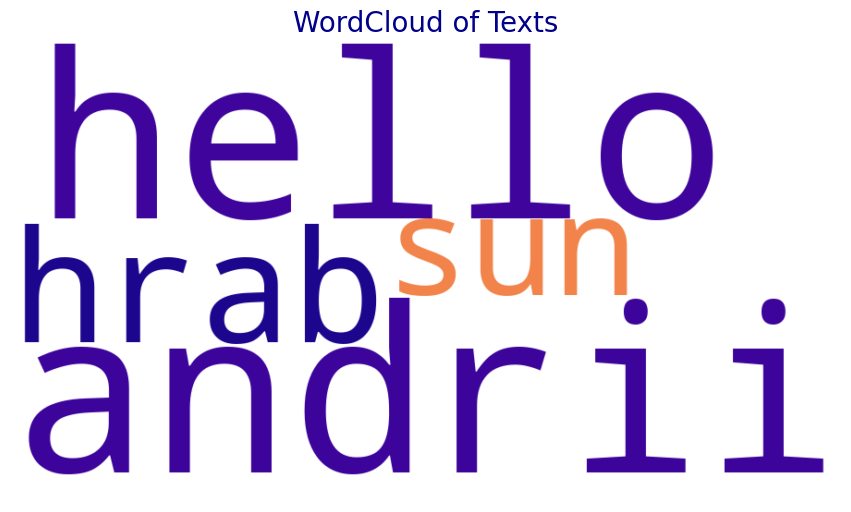

In [20]:
def get_texts():
    """
    Get the texts you want to analyse. Either API fetching, Kaggle or any other source.

    Args:
        None: None.

    Returns:
        list: list of texts.
    """
    texts = [
        "Andrii",
        "Hello",
        "Hrab",
        "Sun",
    ]
    return texts

texts = get_texts()
texts_processed = process_texts(texts)
visualize_texts(texts_processed)
cosine_matrix = calcuate_tfidf(texts_processed)